# USE SYMPY 1.6.2 (and  probably new environment)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as cst
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 14})
from scipy import interpolate
from symfit import parameters, variables, Model, Fit, exp
from symfit.core.minimizers import DifferentialEvolution, LBFGSB
import scipy.constants as cst

# Relevant functions 

In [17]:
def coeff_of_determination(y, f):
    """
    This function computes the coefficient of determination.
        Input:
            y: observed data
            f: fitted/predicted value

        Output:
            R2: coefficient of determination
    """
    mean_y = np.mean(y)

    # Residual sum of squares
    SSres = np.sum((y-f)**2)

    # Total sum of squares
    SStot = np.sum((y-mean_y)**2)

    # Coefficient of determination
    R2 = 1 - (SSres/SStot)

    return R2

In [18]:
def adjusted_coeff_determ(y, f, n, k):
    """
    This function computes the coefficient of determination.
        Input:
            y: observed data
            f: fitted/predicted value
            n: number of observations
            k: number of predictor variables

        Output:
            adjust_R2: ADJUSTED coefficient of determination
    """

    R2 = coeff_of_determination(y, f)
    adjust_R2 = 1- ((1-R2)*(n-1)/(n-k-1))

    return adjust_R2

# 1. Theoretic generated data

## 1.1. Generating theoric data

In [19]:
#from scipy.optimize import fmin as simplex
#DEFINING CONSTANTS
R =cst.R #gas constant [J mol^−1 K^−1]
F= 96485.33212 #[C mol^-1] Faraday constant
T = 273.15 + 37 # [kelvin] temperature const

# Compute reveral potential, using Nernst equation: 
ki = 120e-3 #[M] intracellular concentration
ko = 120e-3   #[M] extracellular concentration
z = 1
E_k = ((R*T)/(z*F))*np.log(ko/ki)*1e3
print(f'Reversal potential computed with Nernst equation:{E_k:3f} mV')

Reversal potential computed with Nernst equation:0.000000 mV


In [20]:
V_amp = np.arange(-100,120,20)
V_amp_str = [str(elem) for elem in V_amp]

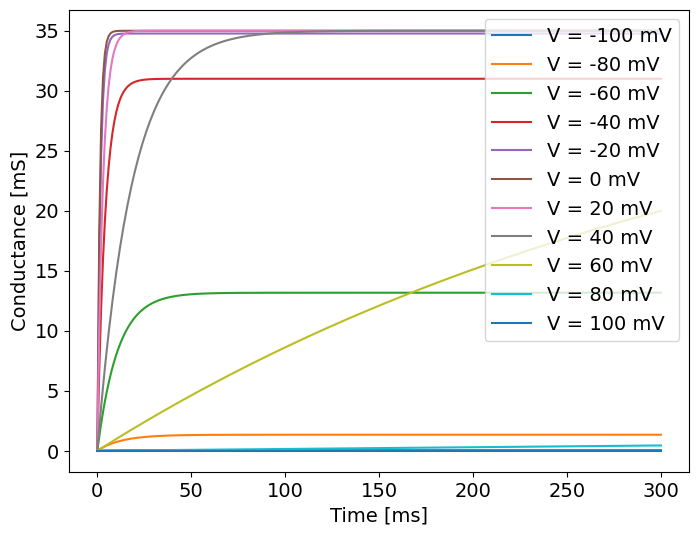

In [21]:
alpham = []
betam = []
m_inf = []
tau_m = []
g_theoretic = []

m0 = 0
g_bar = 35

m = []
t = np.linspace(0,300,300)
t_on = 0 #[ms] Start time of the stimulation


fig, ax= plt.subplots(1,1, figsize= (8,6))

for i, V in enumerate(V_amp):

    alpham.append(0.053*np.exp(-(-260*(V-(-56)) + 2.20*(V-(-56))**2 + 0.0052*(V-(-56))**3)/(R*T))) #[Hz]
    betam.append(0.053*np.exp(-(64.85*(V-(-56)) + 2.02*(V-(-56))**2 + 0.036*(V-(-56))**3)/(R*T))) #[Hz]

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*np.exp(-(t-t_on)/tau_m[i]))
    g_theoretic.append(g_bar*m[i])
    plt.plot(t, g_theoretic[i], label='V = ' + str(V) + " mV")
    plt.xlabel('Time [ms]')
    plt.ylabel('Conductance [mS]')
    plt.legend(loc='upper right')
    


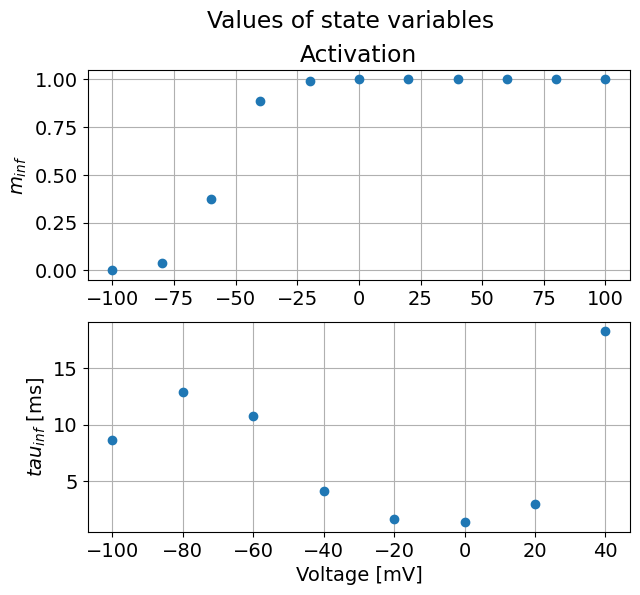

In [7]:
fig, ax = plt.subplots(2,1,figsize= (7,6))
fig.suptitle('Values of state variables')

ax[0].plot(V_amp, m_inf, 'o')
ax[0].set_ylabel(r'$m_{inf}$')
ax[0].grid()
ax[0].set_title('Activation')

V_amp_plot = V_amp[:len(V_amp)-3]
tau_m_plot = tau_m[:len(tau_m)-3]

ax[1].plot(V_amp_plot, tau_m_plot, 'o')
#ax[0][1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel(r'$tau_{inf}$ [ms]')
ax[1].set_xlabel('Voltage [mV]')
ax[1].grid()
plt.savefig('Figures/state_var_gen.png')

## 1.2. Fitting generated data for validation

In [8]:
#Define the model with symfit
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = variables('x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10')
g_bar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m = parameters('gbar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m')

g_bar.min=0.001
g_bar.max=100

Am.min= 0.0001
Am.max= 0.1

Vmm.min= -100
Vmm.max= 100

b1m.min= -500
b1m.max= 500
c1m.min= -10
c1m.max= 10
d1m.min= -0.1
d1m.max= 0.1
b2m.min= -500
b2m.max= 500
c2m.min= -10
c2m.max= 10
d2m.min= -0.1
d2m.max= 0.1


alpham = []
betam = []
m_inf = []
tau_m = []

m0 = 0

m = []
x = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]

t_on = 0 #[ms] Start time of the stimulation


for i in range(len(V_amp_str)):

    alpham.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    betam.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*exp(-(x[i]-t_on)/tau_m[i]))

model = Model({
    y0: g_bar*(m[0]),
    y1: g_bar*(m[1]),
    y2: g_bar*(m[2]),
    y3: g_bar*(m[3]),
    y4: g_bar*(m[4]),
    y5: g_bar*(m[5]),
    y6: g_bar*(m[6]),
    y7: g_bar*(m[7]),
    y8: g_bar*(m[8]),
    y9: g_bar*(m[9]),
    y10: g_bar*(m[10]),
})

In [9]:
fit = Fit(model, 
        x0 = t, y0 =  g_theoretic[0],
        x1 = t, y1 =  g_theoretic[1],
        x2 = t, y2 =  g_theoretic[2],
        x3 = t, y3 =  g_theoretic[3],
        x4 = t, y4 =  g_theoretic[4],
        x5 = t, y5 =  g_theoretic[5],
        x6 = t, y6 =  g_theoretic[6],
        x7 = t, y7 =  g_theoretic[7],
        x8 = t, y8 =  g_theoretic[8],
        x9 = t, y9 =  g_theoretic[9],
        x10 = t, y10 = g_theoretic[10],
        minimizer= [DifferentialEvolution, LBFGSB])
fit_result = fit.execute(DifferentialEvolution={'popsize': 50, 'recombination': 0.9, 'workers':-1})

c:\Users\monoy\OneDrive - epfl.ch\MA4\TNE\Code\.venv\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [10]:
print(fit_result)


Parameter Value        Standard Deviation
Am        5.300089e-02 8.146670e-08
Vmm       -5.599999e+01 3.754409e-06
b1m       -2.599956e+02 2.687971e-04
b2m       6.485390e+01 3.547284e-04
c1m       2.199925e+00 4.750486e-06
c2m       2.019927e+00 1.105588e-05
d1m       5.200352e-03 2.341399e-08
d2m       3.600145e-02 6.537283e-07
gbar      3.500000e+01 1.504079e-06
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   1019
Objective              <symfit.core.objectives.LeastSquares object at 0x000002034F0DFC40>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x000002034F0DE050>, <symfit.core.minimizers.LBFGSB object at 0x000002034F0DF2E0>])

Goodness of fit qualifiers:
chi_squared            5.124386066584025e-07
objective_value        2.562193033292013e-07
r_squared              0.9999999999825899


In [11]:
Am = fit_result.params['Am']
Vmm = fit_result.params['Vmm']
b1m = fit_result.params['b1m']
b2m = fit_result.params['b2m']
c1m = fit_result.params['c1m']
c2m = fit_result.params['c2m']
d1m = fit_result.params['d1m']
d2m = fit_result.params['d2m']
g_bar = fit_result.params['gbar']

In [12]:
y_fit = model(x0 = t, 
              x1 = t, 
              x2 = t,
              x3 = t,
              x4 = t,
              x5 = t, 
              x6 = t, 
              x7 = t, 
              x8 = t, 
              x9 = t, 
              x10 = t,**fit_result.params)

In [13]:
#Need to reorder because of alphabeletical order
test = [y_fit[0], y_fit[1],y_fit[3],y_fit[4],y_fit[5],y_fit[6],y_fit[7],y_fit[8],y_fit[9],y_fit[10],y_fit[2]]

Fit: -100 mV, with adjusted R2=0.9999999479695032
Fit: -80 mV, with adjusted R2=0.9999999971723847
Fit: -60 mV, with adjusted R2=0.9999999997257923
Fit: -40 mV, with adjusted R2=0.9999999999893293
Fit: -20 mV, with adjusted R2=0.9999999999413538
Fit: 0 mV, with adjusted R2=0.9999999999647771
Fit: 20 mV, with adjusted R2=0.999999999993286
Fit: 40 mV, with adjusted R2=0.9999999999969041
Fit: 60 mV, with adjusted R2=0.999999999999907
Fit: 80 mV, with adjusted R2=0.9999999988156879
Fit: 100 mV, with adjusted R2=0.999999987591439


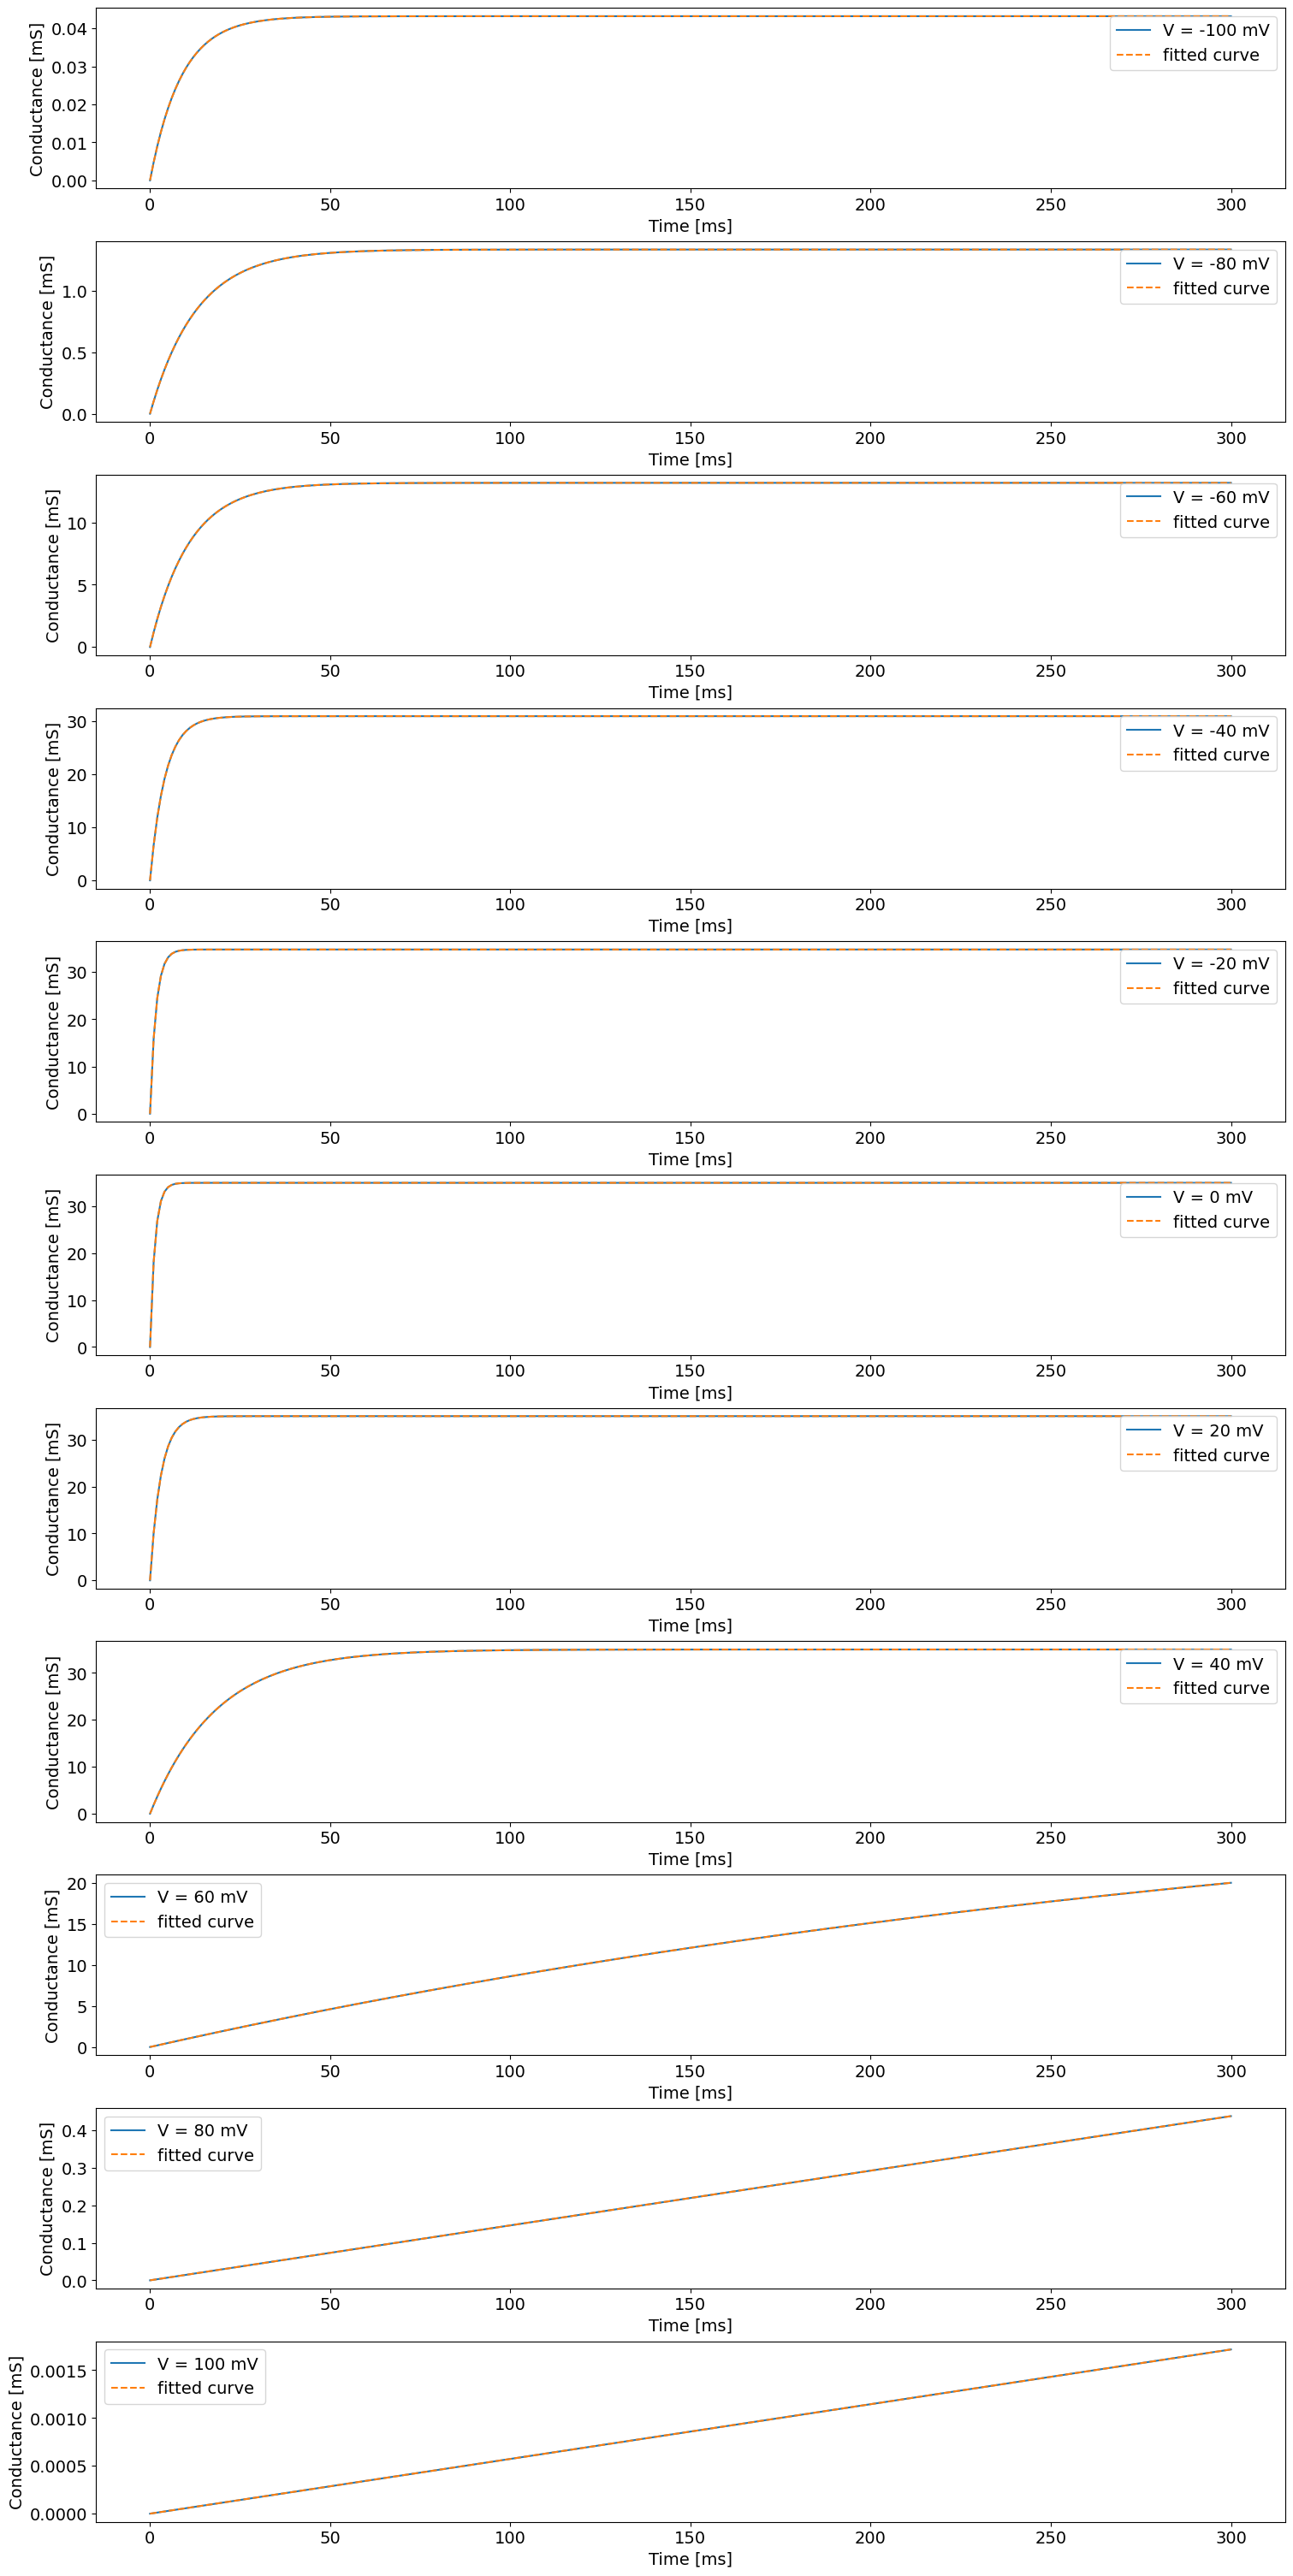

In [14]:
fig, ax= plt.subplots(11, 1, constrained_layout=True, figsize=(15, 30))

for idx, value in enumerate(V_amp_str):
    
    ax[idx].plot(t, g_theoretic[idx], label= 'V = ' + value + " mV")
    ax[idx].plot(t, test[idx], '--', label = 'fitted curve')
    ax[idx].set_xlabel('Time [ms]')
    ax[idx].set_ylabel('Conductance [mS]')
    ax[idx].legend()

    print('Fit: {} mV, with adjusted R2={}'.format(value, adjusted_coeff_determ(g_theoretic[idx], test[idx], len(t), 9)))

plt.savefig('Figures/fit_gen_data.png')


In [35]:
#Calculate state variables
alpha = []
beta = []
n_inf = []
tau = []

for i, value in enumerate(V_amp):
    alpha.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    beta.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

for i, value in enumerate(V_amp):
    n_inf.append(alpha[i]/(alpha[i]+beta[i]))
    tau.append(1/(alpha[i]+beta[i]))

Text(0.5, 1.0, 'Activation')

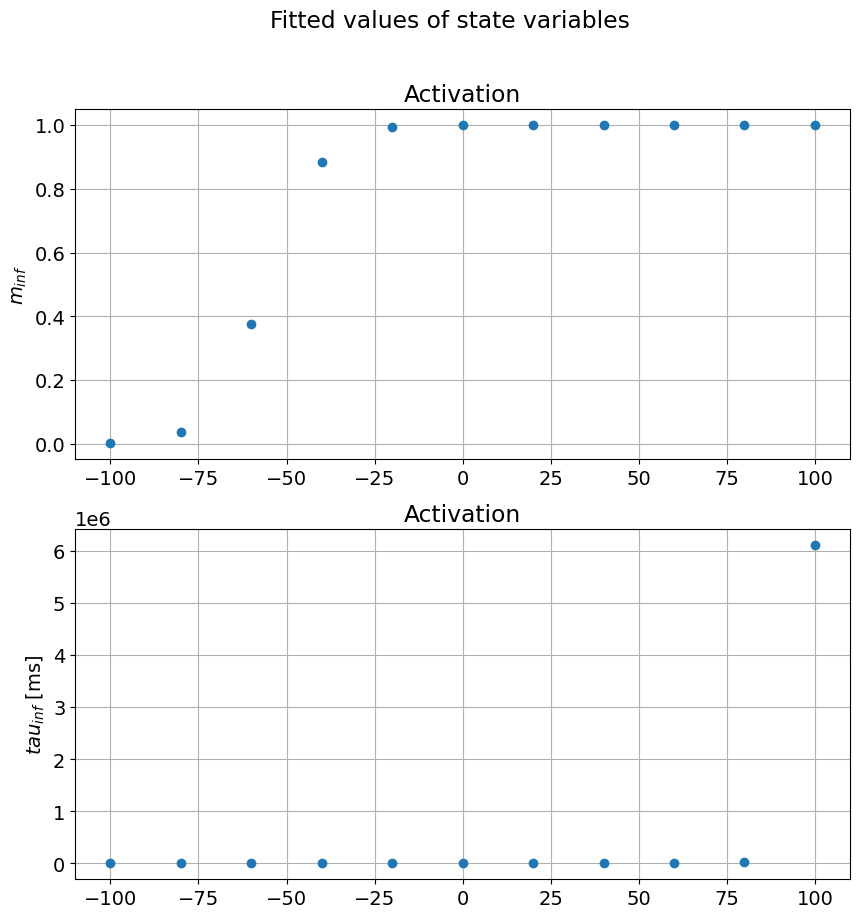

In [37]:
fig, ax = plt.subplots(2,1,figsize= (10,10))
fig.suptitle('Values of state variables')

ax[0].plot(V_amp, m_inf, 'o')
ax[0].set_ylabel(r'$m_{inf}$')
ax[0].grid()
ax[0].set_title('Activation')

V_amp_plot = V_amp[:len(V_amp)-3]
tau_m_plot = tau_m[:len(tau_m)-3]

ax[1].plot(V_amp_plot, tau_m_plot, 'o')
#ax[0][1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel(r'$tau_{inf}$ [ms]')
ax[1].set_xlabel('Voltage [mV]')
ax[1].grid()
ax[1].set_title('Activation')

# 2. Experimental Data

## 2.1. Load data

In [22]:
V_amp = np.arange(-100,120,20)
V_amp_str = [str(elem) for elem in V_amp]
V_data = {}
PATH_TO_DATA='Data/Voltage dependence/'

In [23]:
for idx, value in enumerate(V_amp_str):
    V_data[value] = pd.read_csv(PATH_TO_DATA + value + '.csv', header=0, names=['x', 'y'], comment='#')

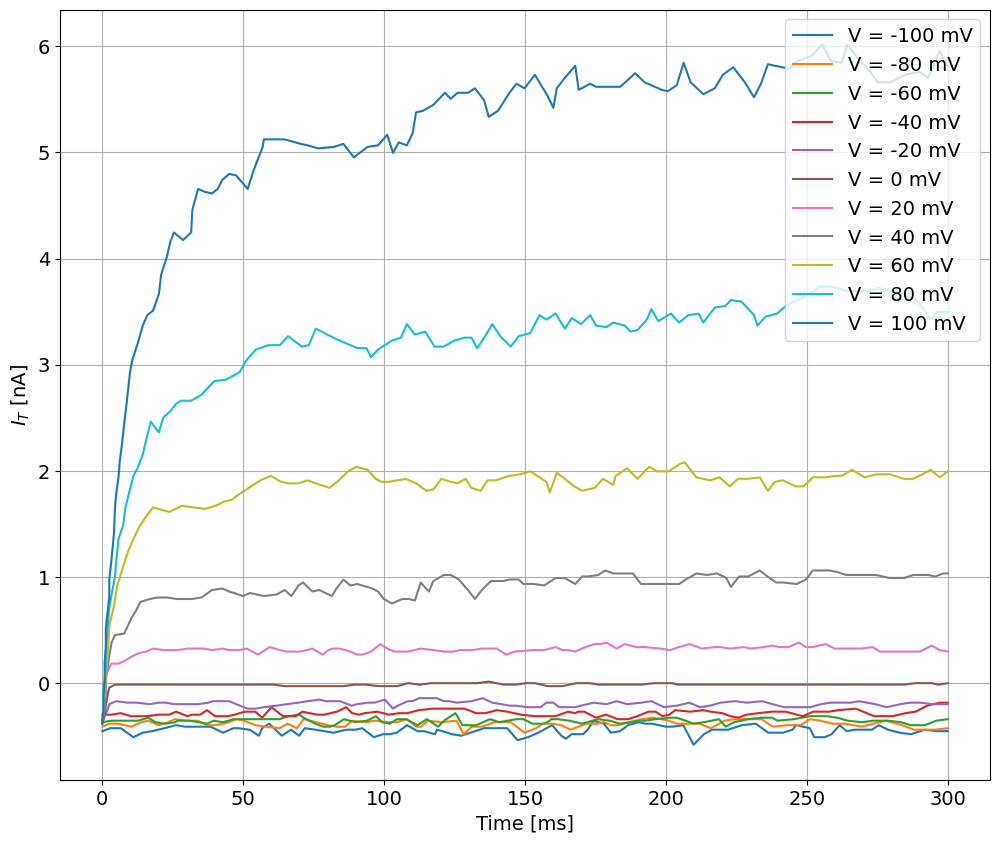

In [24]:
# Look at what the data I extracted look like
fig, ax= plt.subplots(1,1, figsize= (12,10))
for idx, value in enumerate(V_amp_str):
    plt.plot(V_data[value].x, V_data[value].y, label='V = ' + value + " mV")
plt.xlabel("Time [ms]")
plt.ylabel("Current [nA]")
plt.grid()
plt.legend(loc='upper right');

## 2.2. Compute the conductance:

$g = \frac{I}{(V-V_{rev})}$,

where $g$ is the conductance, $V_{rev}=E_{k+}= 0$ mV the reversal potential, and $I$ the current.\
We study potassium ion channels. This comes from the article.

We compute the reversal potential for Potassium in more details, using the Nernst equation:

The intra and extra cellular concentrations are the same 
$E = \frac{RT}{zF} \ln \frac{[\text{ion outside cell}]}{[\text{ion inside cell}]}$

In [45]:
g_data ={} 
for idx, value in enumerate(V_amp_str):
    g_data[value] = (V_data[value].y/(V_amp[idx]-E_k)).to_frame().join(V_data[value].x)

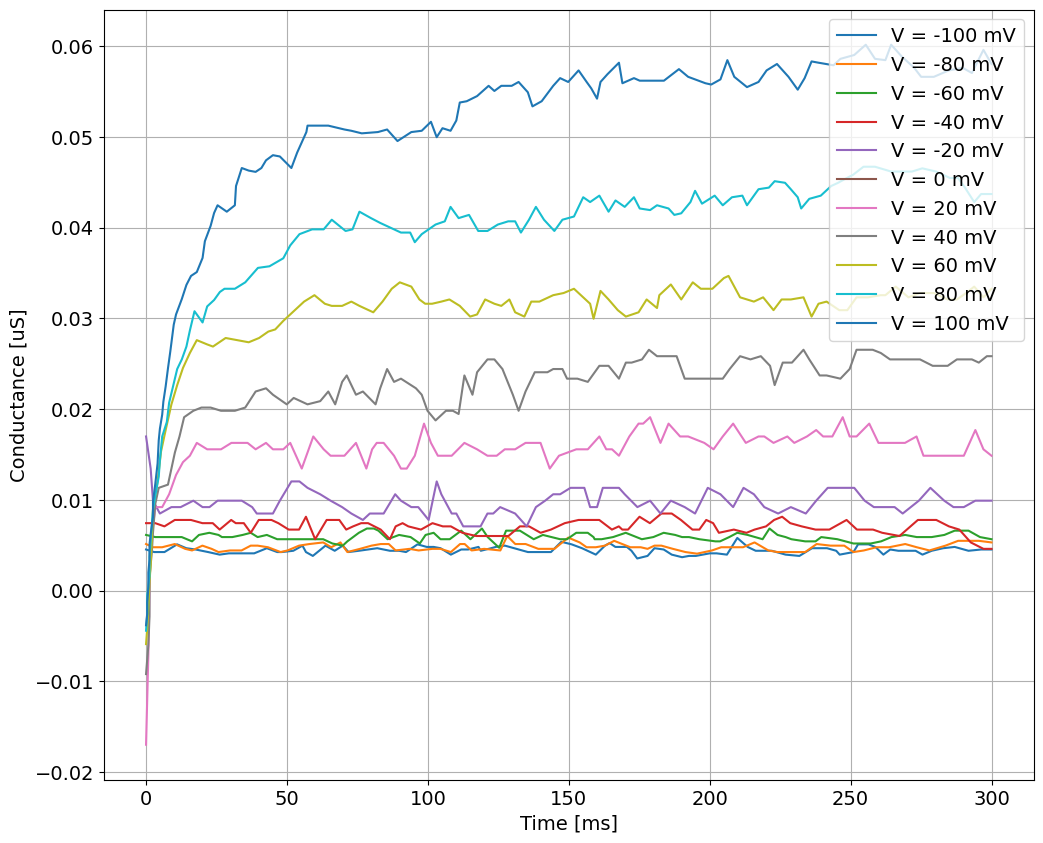

In [47]:
# Look at what the data I extracted look like
fig, ax= plt.subplots(1,1, figsize= (12,10))

for idx, value in enumerate(V_amp_str):
    plt.plot(g_data[value].x, g_data[value].y, label='V = ' + value + " mV")
    
plt.xlabel("Time [ms]")
plt.ylabel('Conductance [uS]')
plt.grid()
plt.legend(loc='upper right');

## 2.3. Fitting experimental data

In [73]:
V_amp = [-100, -80, -60, -40, -20, 20, 40, 60, 80, 100]
V_amp_str = ['-100', '-80','-60','-40','-20','20','40','60','80','100'] 


In [49]:
#Define the model with symfit
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 = variables('x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9')
g_bar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m = parameters('gbar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m')

g_bar.min=0.001
g_bar.max=1

Am.min= 0.0001
Am.max= 0.1

Vmm.min= -100
Vmm.max= 100

b1m.min= -500
b1m.max= 500
c1m.min= -10
c1m.max= 10
d1m.min= -0.1
d1m.max= 0.1
b2m.min= -500
b2m.max= 500
c2m.min= -10
c2m.max= 10
d2m.min= -0.1
d2m.max= 0.1


alpham = []
betam = []
m_inf = []
tau_m = []

#g_base = 0.005
h = 1
#m0 = (g_base/(g_bar*h))
V_m0 = -80.01
alpham0 = (Am*exp(-(b1m*(V_m0-Vmm) + c1m*(V_m0-Vmm)**2 + d1m*(V_m0-Vmm)**3)/(R*T)))
betam0 = (Am*exp(-(b2m*(V_m0-Vmm) + c2m*(V_m0-Vmm)**2 + d2m*(V_m0-Vmm)**3)/(R*T)))

m0 = (alpham0)/(alpham0+betam0) 

m = []
x = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]

t_on = 0 #[ms] Start time of the stimulation


for i in range(len(V_amp_str)):

    alpham.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    betam.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*exp(-(x[i]-t_on)/tau_m[i]))

model = Model({
    y0: g_bar*h*(m[0]),
    y1: g_bar*h*(m[1]),
    y2: g_bar*h*(m[2]),
    y3: g_bar*h*(m[3]),
    y4: g_bar*h*(m[4]),
    y5: g_bar*h*(m[5]),
    y6: g_bar*h*(m[6]),
    y7: g_bar*h*(m[7]),
    y8: g_bar*h*(m[8]),
    y9: g_bar*h*(m[9]),
})

In [50]:
fit = Fit(model, 
        x0 = V_data['-100'].x.to_numpy(), y0 = g_data['-100'].y.to_numpy(),
        x1 = V_data['-80'].x.to_numpy(), y1 = g_data['-80'].y.to_numpy(),
        x2 = V_data['-60'].x.to_numpy(), y2 = g_data['-60'].y.to_numpy(),
        x3 = V_data['-40'].x.to_numpy(), y3 = g_data['-40'].y.to_numpy(),
        x4 = V_data['-20'].x.to_numpy(), y4 = g_data['-20'].y.to_numpy(),
        x5 = V_data['20'].x.to_numpy(), y5 = g_data['20'].y.to_numpy(),
        x6 = V_data['40'].x.to_numpy(), y6 = g_data['40'].y.to_numpy(),
        x7 = V_data['60'].x.to_numpy(), y7 = g_data['60'].y.to_numpy(),
        x8 = V_data['80'].x.to_numpy(), y8 = g_data['80'].y.to_numpy(),
        x9 = V_data['100'].x.to_numpy(), y9 = g_data['100'].y.to_numpy(),
        minimizer= [DifferentialEvolution, LBFGSB])
fit_result = fit.execute(DifferentialEvolution={'popsize': 50, 'recombination': 0.9, 'workers':-1})

c:\Users\monoy\OneDrive - epfl.ch\MA4\TNE\Code\.venv\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [51]:
print(fit_result)


Parameter Value        Standard Deviation
Am        2.756769e-02 1.402389e-03
Vmm       7.704963e+01 6.159321e+00
b1m       -2.440201e+01 4.726554e+00
b2m       4.802552e+01 6.714877e+00
c1m       -1.712336e-01 2.138777e-01
c2m       4.493341e-02 2.137101e-01
d1m       4.181831e-03 3.829649e-03
d2m       4.526902e-03 3.931117e-03
gbar      8.256491e-02 6.946610e-03
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   516
Objective              <symfit.core.objectives.LeastSquares object at 0x000001B6C4D64820>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x000001B6C4D645E0>, <symfit.core.minimizers.LBFGSB object at 0x000001B6C4D64640>])

Goodness of fit qualifiers:
chi_squared            0.0043905338650416115
objective_value        0.0021952669325208058
r_squared              0.9319904107793734


In [25]:
print(fit_result)


Parameter Value        Standard Deviation
Am        2.833351e-02 2.529470e-03
Vmm       8.552550e+01 1.630491e+01
b1m       -2.199093e+01 1.480647e+01
b2m       4.676314e+01 7.031058e+00
c1m       4.466550e-01 4.948886e-01
c2m       6.140583e-01 3.948835e-01
d1m       9.131384e-03 3.536032e-03
d2m       9.328823e-03 3.629764e-03
gbar      9.231140e-02 1.970796e-02
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   475
Objective              <symfit.core.objectives.LeastSquares object at 0x7ffa597dbfd0>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x7ffa415819a0>, <symfit.core.minimizers.LBFGSB object at 0x7ffa41581fa0>])

Goodness of fit qualifiers:
chi_squared            0.004363915765971662
objective_value        0.002181957882985831
r_squared              0.9324027264656263


In [52]:
y_fit = model(x0 = V_data['-100'].x.to_numpy(), 
              x1 = V_data['-80'].x.to_numpy(), 
              x2 = V_data['-60'].x.to_numpy(),
              x3 = V_data['-40'].x.to_numpy(),
              x4 = V_data['-20'].x.to_numpy(),
              x5 = V_data['20'].x.to_numpy(), 
              x6 = V_data['40'].x.to_numpy(), 
              x7 = V_data['60'].x.to_numpy(), 
              x8 = V_data['80'].x.to_numpy(), 
              x9 = V_data['100'].x.to_numpy(),**fit_result.params)

In [53]:
test = [y_fit[0], y_fit[1],y_fit[2], y_fit[3],y_fit[4],y_fit[5],y_fit[6],y_fit[7],y_fit[8],y_fit[9]]

Fit: -100 mV, with adjusted R2=-4.883022036493488
Fit: -80 mV, with adjusted R2=-0.9256173103647671
Fit: -60 mV, with adjusted R2=-0.9017138365844324
Fit: -40 mV, with adjusted R2=-0.3205781051227157
Fit: -20 mV, with adjusted R2=-0.8503486246325809
Fit: 20 mV, with adjusted R2=0.5516414187572802
Fit: 40 mV, with adjusted R2=0.7997104521173397
Fit: 60 mV, with adjusted R2=0.9186064936430285
Fit: 80 mV, with adjusted R2=0.9548506456376715
Fit: 100 mV, with adjusted R2=0.9686048734051761


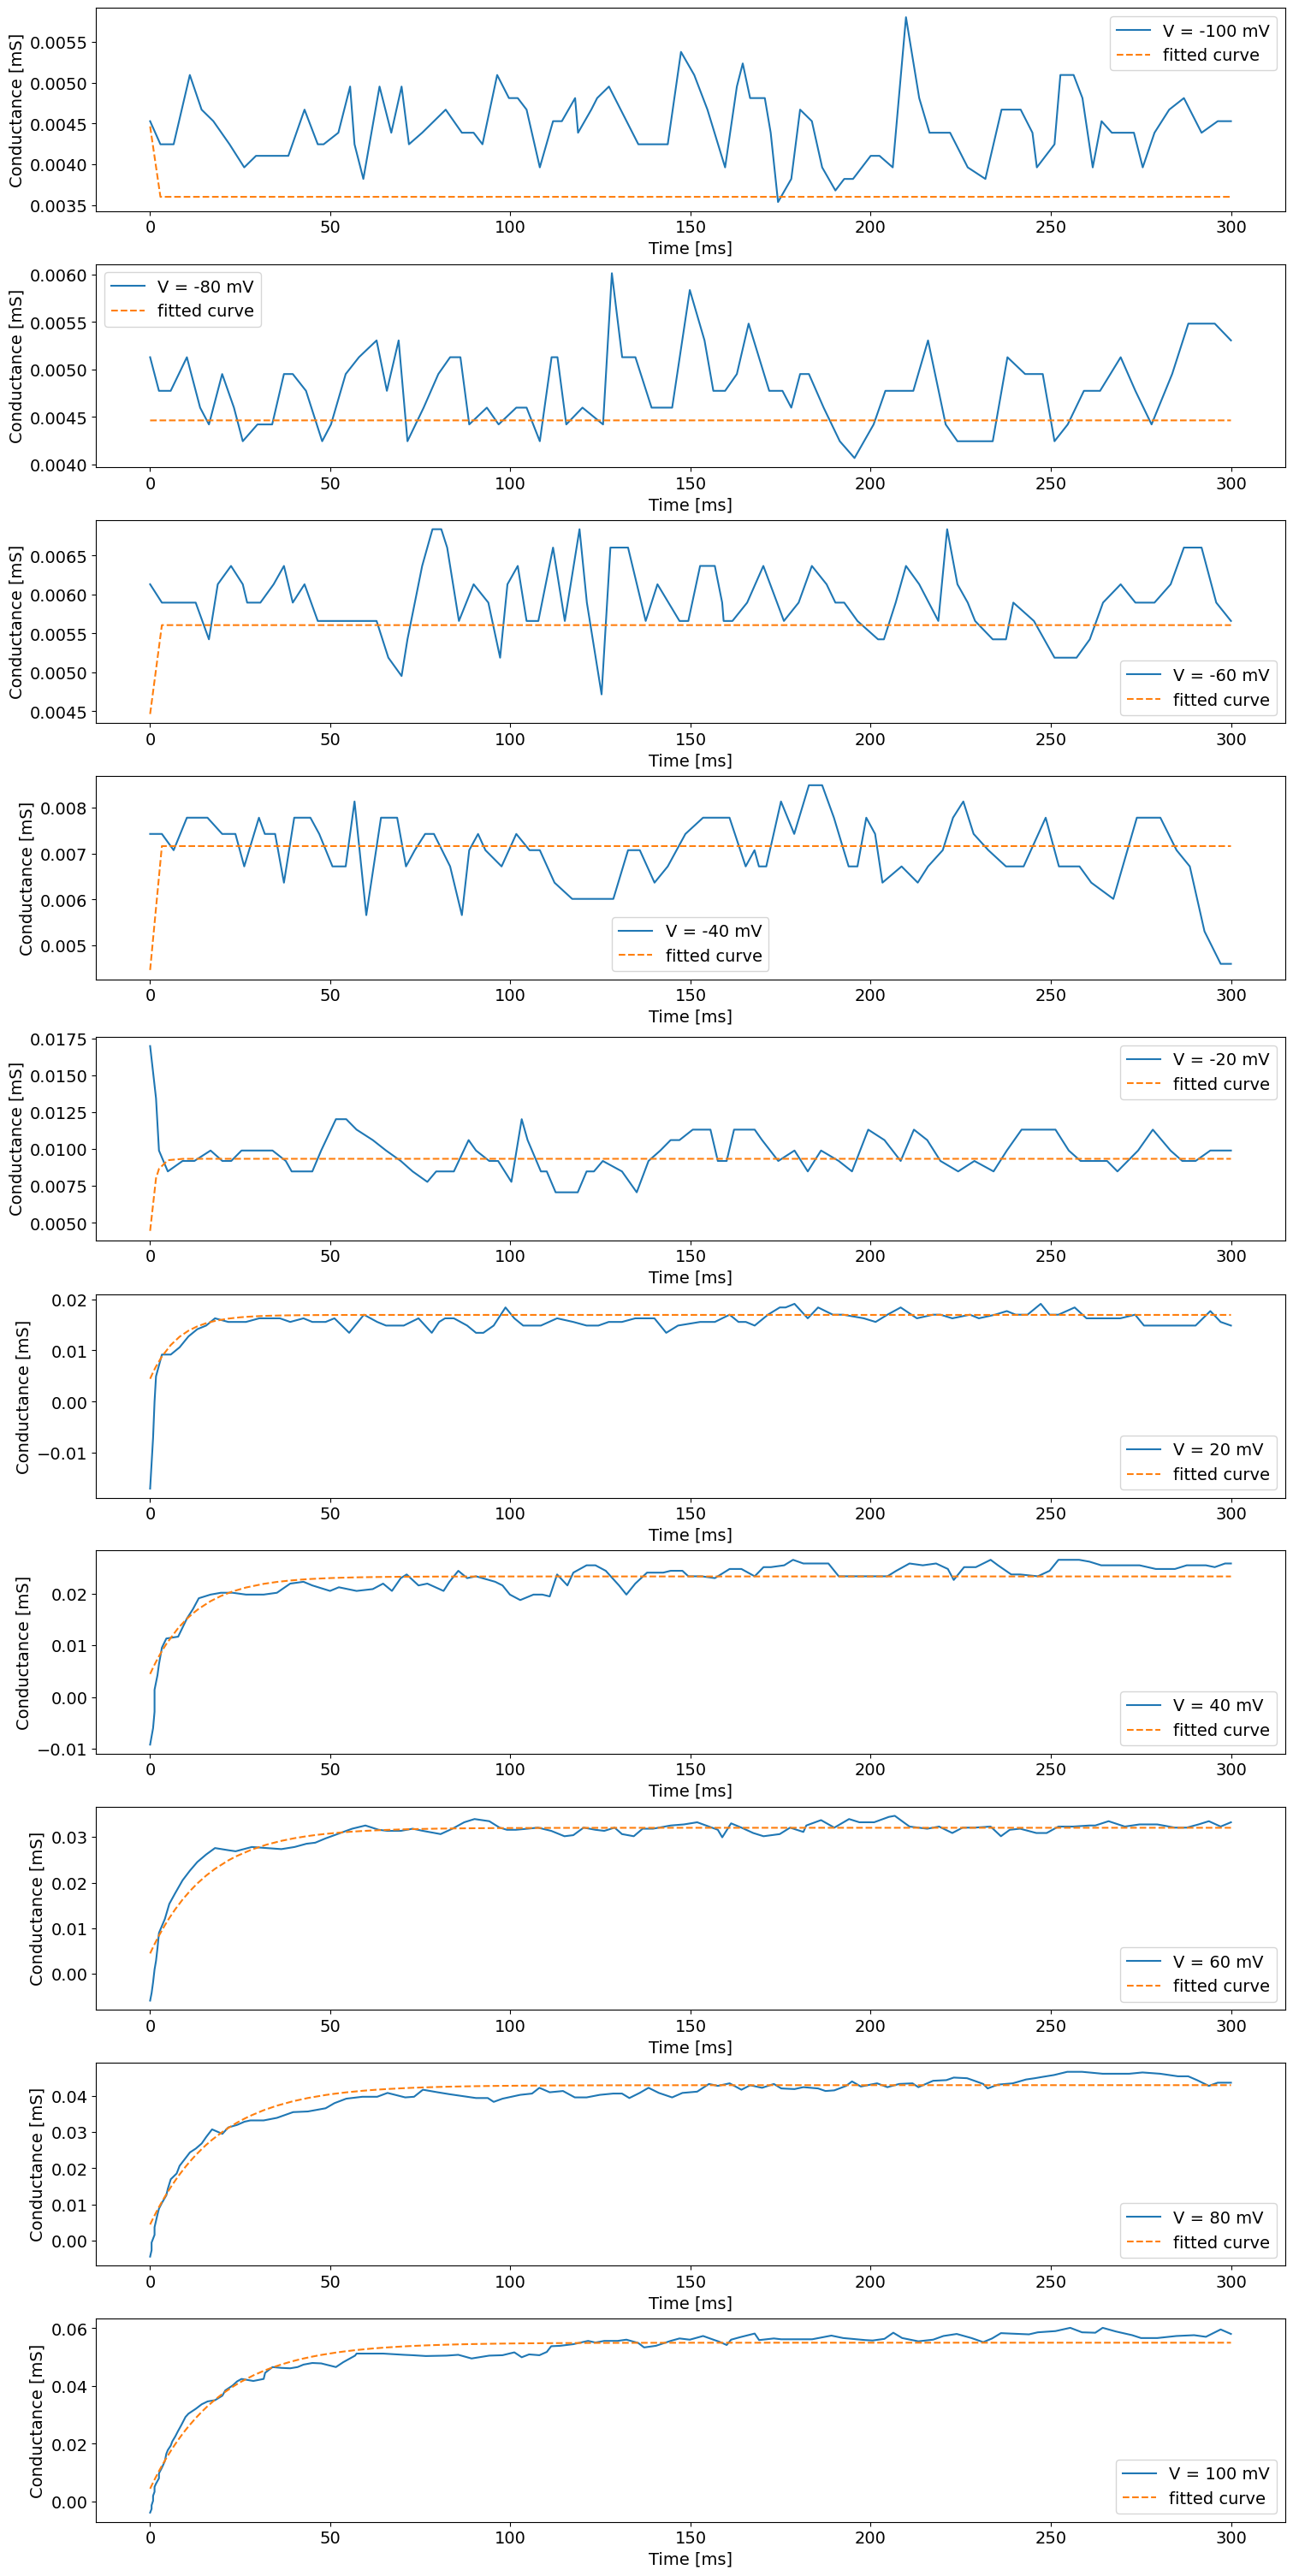

In [64]:
fig, ax= plt.subplots(10, 1, constrained_layout=True, figsize=(15, 30))

for idx, value in enumerate(V_amp_str):
    
    ax[idx].plot(g_data[value].x, g_data[value].y, label= 'V = ' + value + " mV")
    ax[idx].plot(g_data[value].x, test[idx], '--',  label = 'fitted curve')
    ax[idx].set_xlabel('Time [ms]')
    ax[idx].set_ylabel('Conductance [mS]')
    ax[idx].legend()
    print('Fit: {} mV, with adjusted R2={}'.format(value, adjusted_coeff_determ(g_data[value].y, test[idx], len(V_data[value].x), 9)))

plt.savefig('Figures/fit_exp_data.png')


In [65]:
Am = fit_result.params['Am']
Vmm = fit_result.params['Vmm']
b1m = fit_result.params['b1m']
b2m = fit_result.params['b2m']
c1m = fit_result.params['c1m']
c2m = fit_result.params['c2m']
d1m = fit_result.params['d1m']
d2m = fit_result.params['d2m']
g_bar = fit_result.params['gbar']

In [78]:
#Calculate state variables
alpha = []
beta = []
m_inf = []
tau_m = []

for i, value in enumerate(V_amp):
    alpha.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    beta.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

for i, value in enumerate(V_amp):
    m_inf.append(alpha[i]/(alpha[i]+beta[i]))
    tau_m.append(1/(alpha[i]+beta[i]))

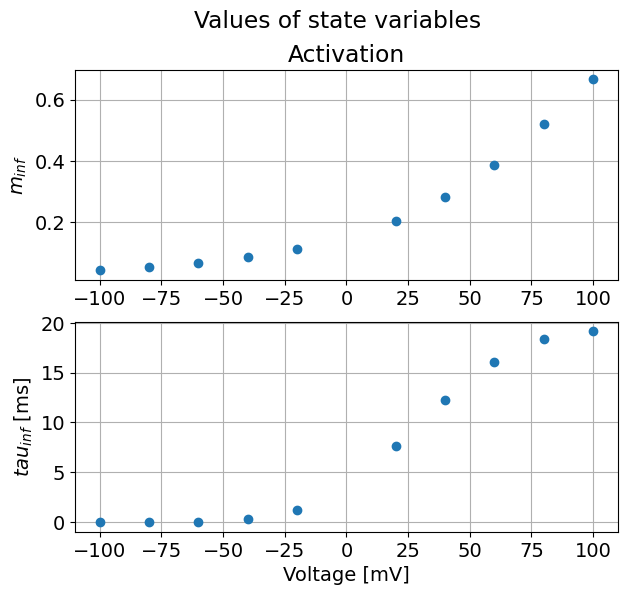

In [80]:
fig, ax = plt.subplots(2,1,figsize= (7,6))
fig.suptitle('Values of state variables')

ax[0].plot(V_amp, m_inf, 'o')
ax[0].set_ylabel(r'$m_{inf}$')
ax[0].grid()
ax[0].set_title('Activation')

ax[1].plot(V_amp, tau_m, 'o')
#ax[0][1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel(r'$tau_{inf}$ [ms]')
ax[1].set_xlabel('Voltage [mV]')
ax[1].grid()
plt.savefig('Figures/state_var_exp.png')

## 2.4. Generate data with fitted parameters for validation

In [25]:
V_amp = np.arange(-100,120,20)
V_amp_str = [str(elem) for elem in V_amp]

In [26]:
Am    =    2.756769e-02 
Vmm   =    7.704963e+01
b1m   =    -2.440201e+01 
b2m   =    4.802552e+01 
c1m   =    -1.712336e-01 
c2m    =   4.493341e-02 
d1m     =  4.181831e-03 
d2m     =  4.526902e-03 
g_bar  =    8.256491e-02 

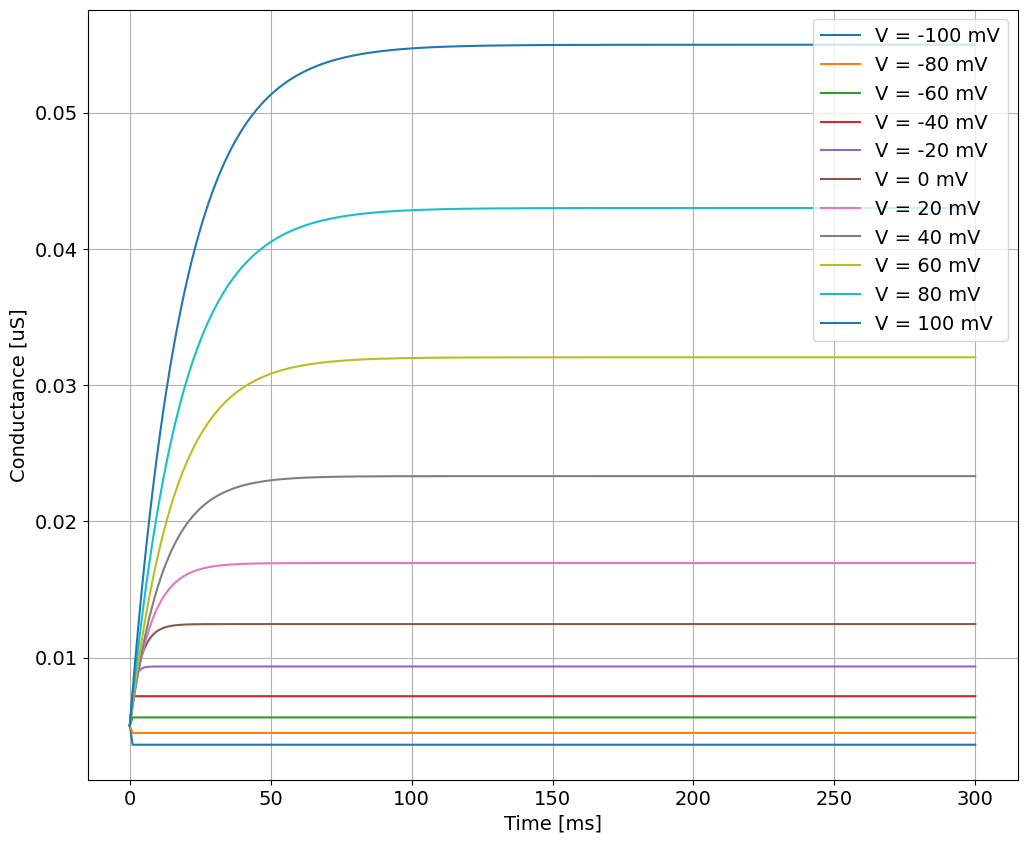

In [27]:
alpham = []
betam = []
m_inf = []
tau_m = []
g_theoretic = []

g_base = 0.005
h = 1
m0 = (g_base/(g_bar*h))
#V_m0 = -80
#alpham0 = (Am*exp(-(b1m*(V_m0-Vmm) + c1m*(V_m0-Vmm)**2 + d1m*(V_m0-Vmm)**3)/(R*T)))
#betam0 = (Am*exp(-(b2m*(V_m0-Vmm) + c2m*(V_m0-Vmm)**2 + d2m*(V_m0-Vmm)**3)/(R*T)))

#m0 = (alpham0)/(alpham0+betam0) 

m = []
t = np.linspace(0,300,300)
t_on = 0 #[ms] Start time of the stimulation


fig, ax= plt.subplots(1,1, figsize= (12,10))

for i, V in enumerate(V_amp):
    alpham.append(Am*np.exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    betam.append(Am*np.exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*np.exp(-(t-t_on)/tau_m[i]))
    
    g_theoretic.append(g_bar*m[i])
    plt.plot(t, g_theoretic[i], label='V = ' + str(V) + " mV")
    plt.xlabel("Time [ms]")
    plt.ylabel('Conductance [uS]')
    plt.grid()
    plt.legend(loc='upper right')
    

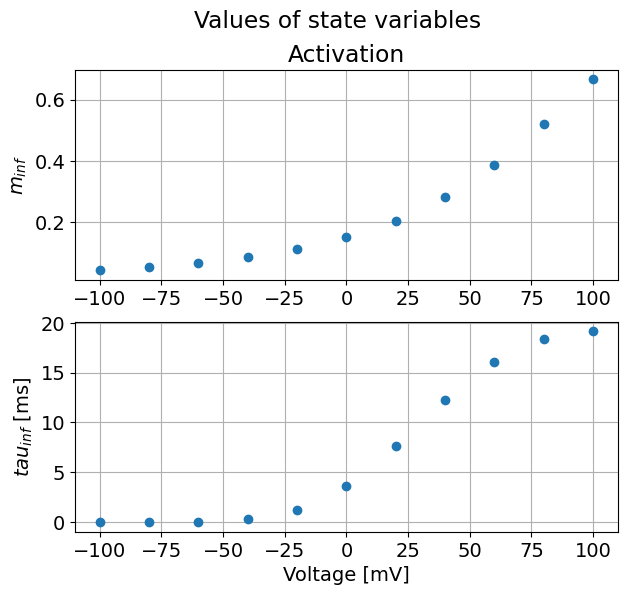

In [28]:
fig, ax = plt.subplots(2,1,figsize= (7,6))
fig.suptitle('Values of state variables')

ax[0].plot(V_amp, m_inf, 'o')
ax[0].set_ylabel(r'$m_{inf}$')
ax[0].grid()
ax[0].set_title('Activation')

ax[1].plot(V_amp, tau_m, 'o')
#ax[0][1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel(r'$tau_{inf}$ [ms]')
ax[1].set_xlabel('Voltage [mV]')
ax[1].grid()
plt.savefig('Figures/state_var_gen_exp.png')

## 2.5. Fitting generated data for validation

In [93]:
#Define the model with symfit
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = variables('x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y0, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10')
g_bar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m = parameters('gbar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m')

g_bar.min=0.001
g_bar.max=1

Am.min= 0.0001
Am.max= 0.1

Vmm.min= -100
Vmm.max= 100

b1m.min= -500
b1m.max= 500
c1m.min= -10
c1m.max= 10
d1m.min= -0.1
d1m.max= 0.1
b2m.min= -500
b2m.max= 500
c2m.min= -10
c2m.max= 10
d2m.min= -0.1
d2m.max= 0.1


alpham = []
betam = []
m_inf = []
tau_m = []

g_base = 0.005
h = 1
m0 = (g_base/(g_bar*h))
#V_m0 = -80.01
#alpham0 = (Am*exp(-(b1m*(V_m0-Vmm) + c1m*(V_m0-Vmm)**2 + d1m*(V_m0-Vmm)**3)/(R*T)))
#betam0 = (Am*exp(-(b2m*(V_m0-Vmm) + c2m*(V_m0-Vmm)**2 + d2m*(V_m0-Vmm)**3)/(R*T)))

#m0 = (alpham0)/(alpham0+betam0) 

m = []
x = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]

t_on = 0 #[ms] Start time of the stimulation


for i in range(len(V_amp_str)):

    alpham.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    betam.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*exp(-(x[i]-t_on)/tau_m[i]))

model = Model({
    y0: g_bar*h*(m[0]),
    y1: g_bar*h*(m[1]),
    y2: g_bar*h*(m[2]),
    y3: g_bar*h*(m[3]),
    y4: g_bar*h*(m[4]),
    y5: g_bar*h*(m[5]),
    y6: g_bar*h*(m[6]),
    y7: g_bar*h*(m[7]),
    y8: g_bar*h*(m[8]),
    y9: g_bar*h*(m[9]),
    y10: g_bar*h*(m[10]),
})

In [94]:
fit = Fit(model, 
        x0 = t, y0 =  g_theoretic[0],
        x1 = t, y1 =  g_theoretic[1],
        x2 = t, y2 =  g_theoretic[2],
        x3 = t, y3 =  g_theoretic[3],
        x4 = t, y4 =  g_theoretic[4],
        x5 = t, y5 =  g_theoretic[5],
        x6 = t, y6 =  g_theoretic[6],
        x7 = t, y7 =  g_theoretic[7],
        x8 = t, y8 =  g_theoretic[8],
        x9 = t, y9 =  g_theoretic[9],
        x10 = t, y10 = g_theoretic[10],
        minimizer= [DifferentialEvolution, LBFGSB])
fit_result = fit.execute(DifferentialEvolution={'popsize': 50, 'recombination': 0.9, 'workers':-1})

c:\Users\monoy\OneDrive - epfl.ch\MA4\TNE\Code\.venv\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [95]:
print(fit_result)


Parameter Value        Standard Deviation
Am        2.756883e-02 4.883512e-07
Vmm       7.703412e+01 2.477867e-03
b1m       -2.438946e+01 2.156809e-03
b2m       4.804973e+01 3.162411e-03
c1m       -1.712274e-01 9.963989e-05
c2m       4.516231e-02 9.046886e-05
d1m       4.179496e-03 1.649296e-06
d2m       4.525496e-03 1.638640e-06
gbar      8.254676e-02 2.769468e-06
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   1001
Objective              <symfit.core.objectives.LeastSquares object at 0x000001B6CB177310>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x000001B6CB174C10>, <symfit.core.minimizers.LBFGSB object at 0x000001B6CB174610>])

Goodness of fit qualifiers:
chi_squared            5.596718562776567e-10
objective_value        2.7983592813882837e-10
r_squared              0.9999999868400936


In [97]:
y_fit = model(x0 = t, 
              x1 = t, 
              x2 = t,
              x3 = t,
              x4 = t,
              x5 = t, 
              x6 = t, 
              x7 = t, 
              x8 = t, 
              x9 = t, 
              x10 = t,**fit_result.params)

In [98]:
test = [y_fit[0], y_fit[1],y_fit[3],y_fit[4],y_fit[5],y_fit[6],y_fit[7],y_fit[8],y_fit[9],y_fit[10],y_fit[2]]

Fit: -100 mV, with adjusted R2=0.9999561166279181
Fit: -80 mV, with adjusted R2=0.9999853248480115
Fit: -60 mV, with adjusted R2=0.9999717979635462
Fit: -40 mV, with adjusted R2=0.9999924285022408
Fit: -20 mV, with adjusted R2=0.9999983110855528
Fit: 0 mV, with adjusted R2=0.9999997874818478
Fit: 20 mV, with adjusted R2=0.9999999348920128
Fit: 40 mV, with adjusted R2=0.999999966804867
Fit: 60 mV, with adjusted R2=0.9999999922448464
Fit: 80 mV, with adjusted R2=0.999999998991809
Fit: 100 mV, with adjusted R2=0.9999999902604396


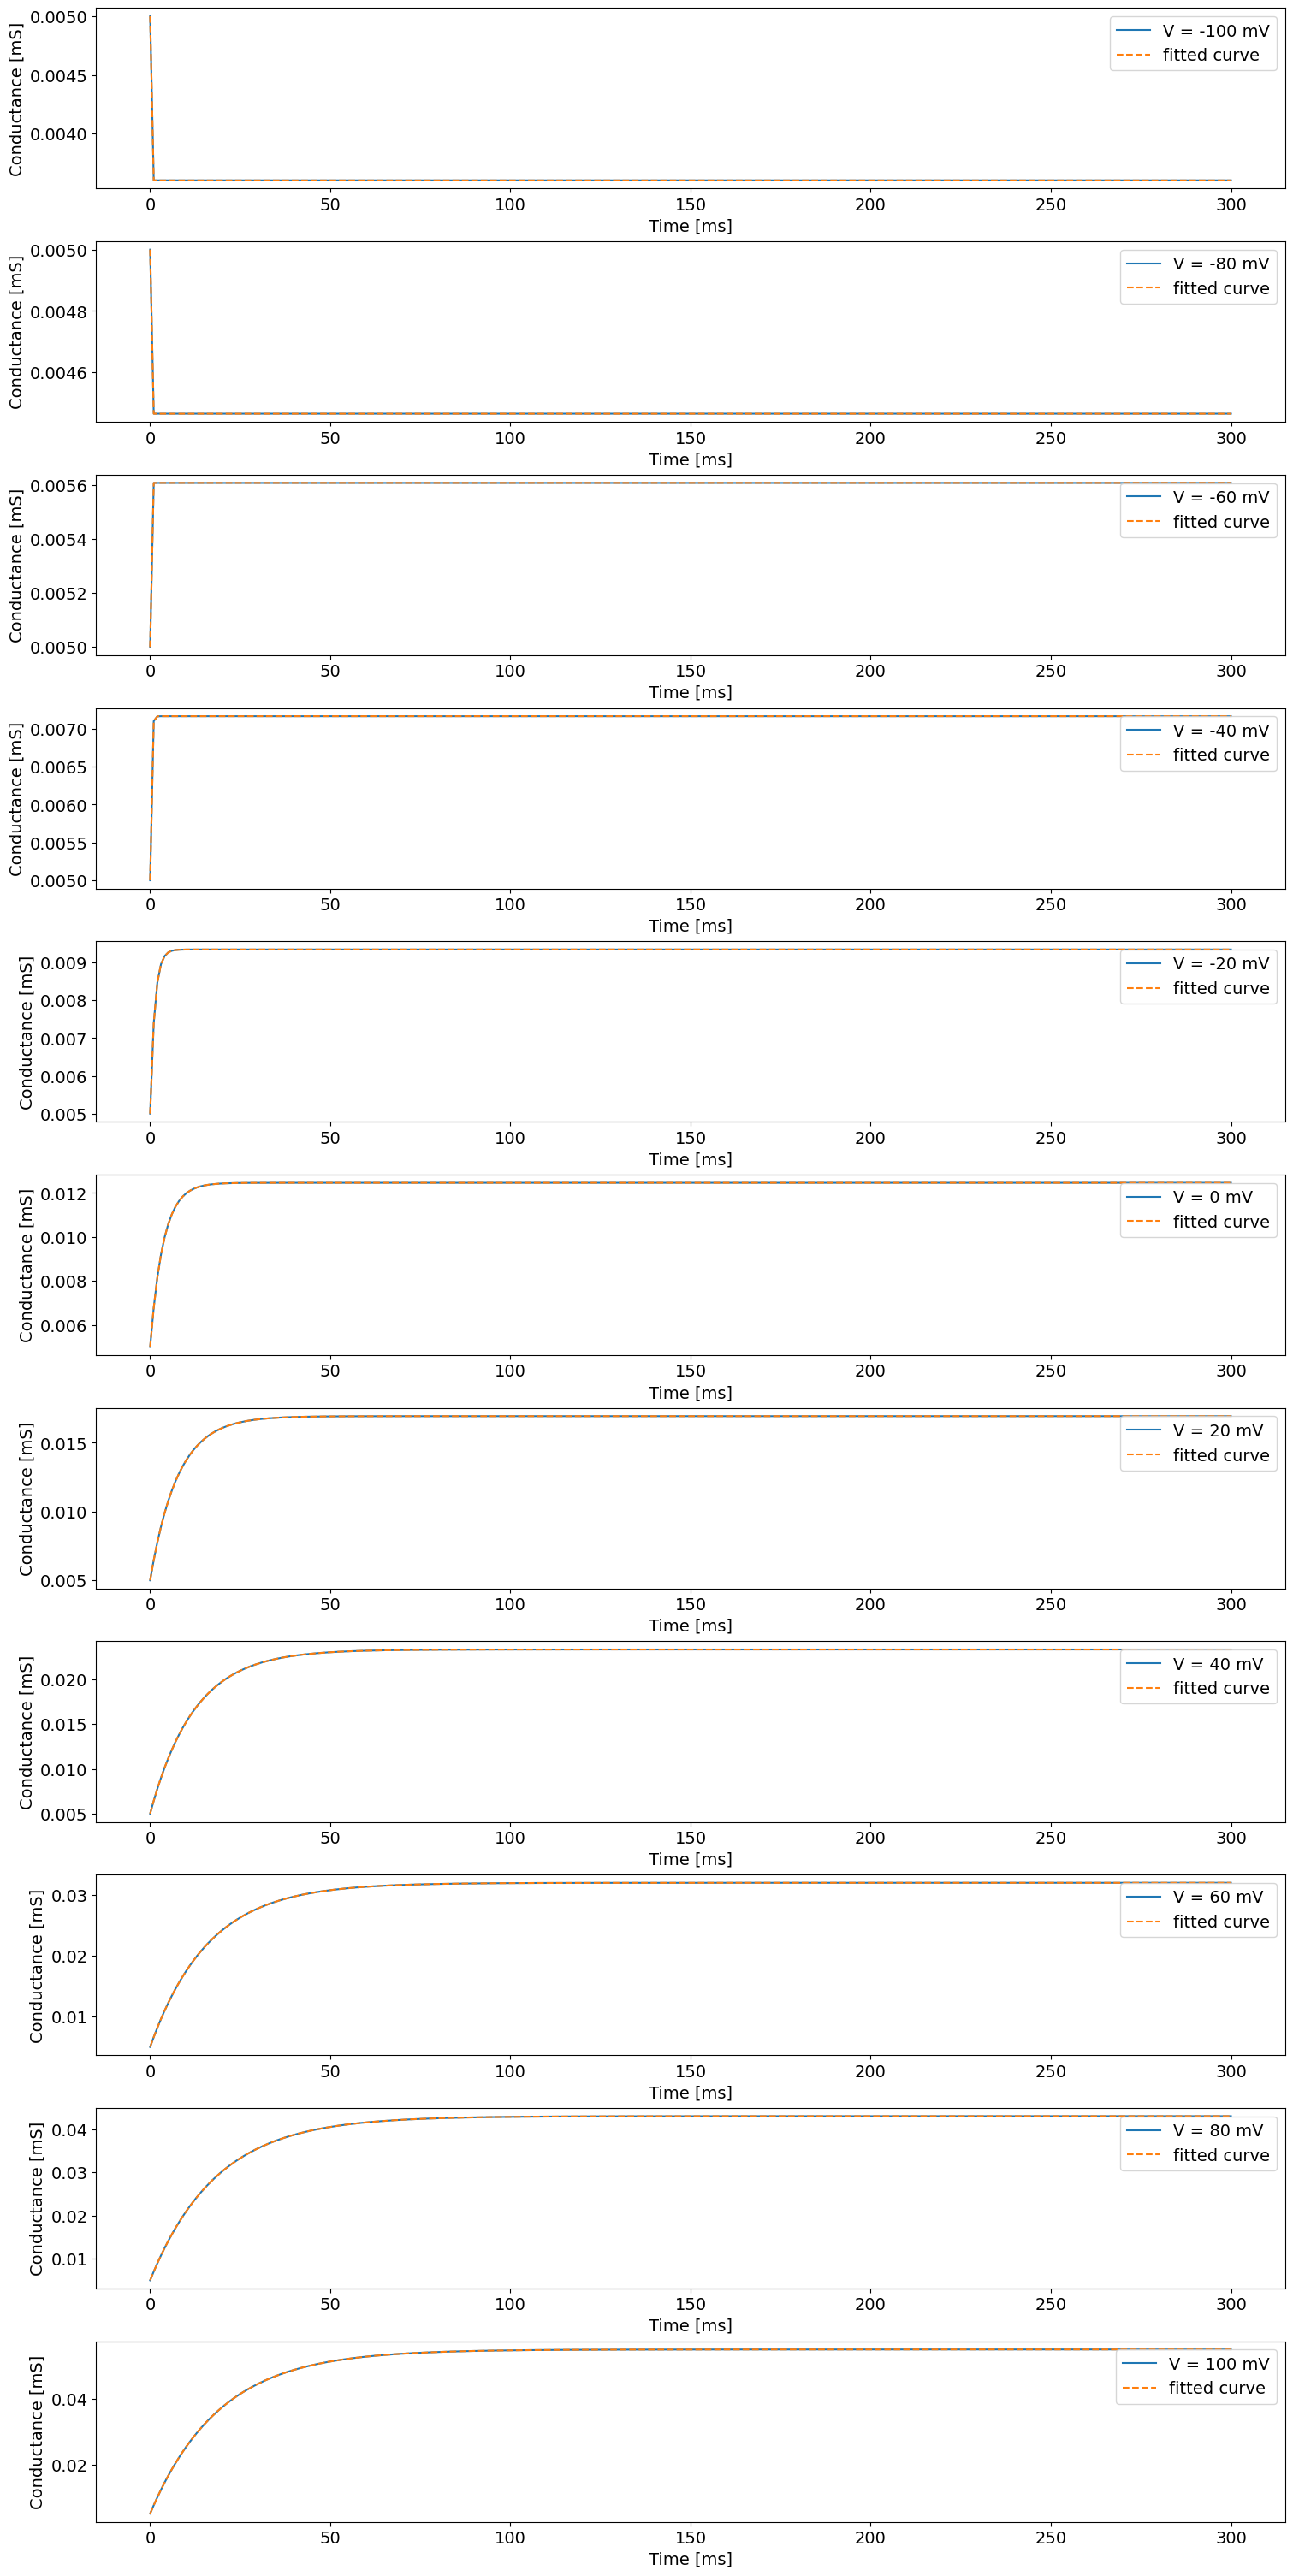

In [99]:
fig, ax= plt.subplots(11, 1, constrained_layout=True, figsize=(15, 30))

for idx, value in enumerate(V_amp_str):
    
    ax[idx].plot(t, g_theoretic[idx], label= 'V = ' + value + " mV")
    ax[idx].plot(t, test[idx], '--', label = 'fitted curve')
    ax[idx].set_xlabel('Time [ms]')
    ax[idx].set_ylabel('Conductance [mS]')
    ax[idx].legend()

    print('Fit: {} mV, with adjusted R2={}'.format(value, adjusted_coeff_determ(g_theoretic[idx], test[idx], len(t), 9)))

plt.savefig('Figures/fit_gen_exp_data.png')


In [100]:
Am = fit_result.params['Am']
Vmm = fit_result.params['Vmm']
b1m = fit_result.params['b1m']
b2m = fit_result.params['b2m']
c1m = fit_result.params['c1m']
c2m = fit_result.params['c2m']
d1m = fit_result.params['d1m']
d2m = fit_result.params['d2m']
gbar = fit_result.params['gbar']

In [103]:
alpha = []
beta = []
n_inf = []
tau = []

for i, value in enumerate(V_amp):
    alpha.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    beta.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

for i, value in enumerate(V_amp):
    n_inf.append(alpha[i]/(alpha[i]+beta[i]))
    tau.append(1/(alpha[i]+beta[i]))

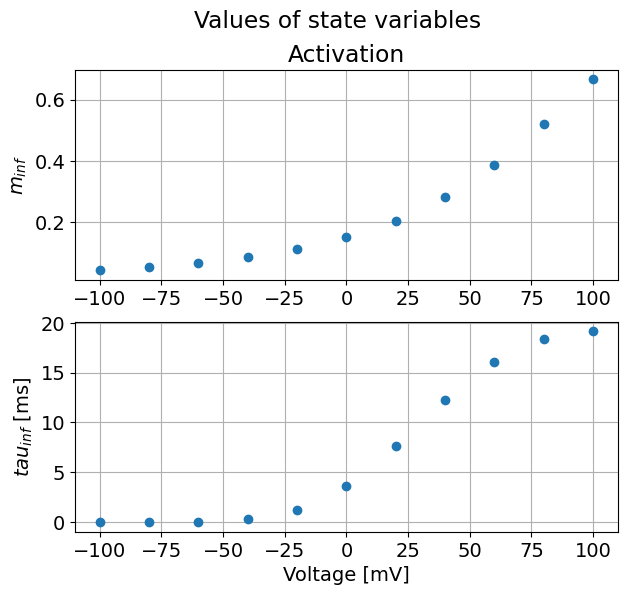

In [105]:
fig, ax = plt.subplots(2,1,figsize= (7,6))
fig.suptitle('Values of state variables')

ax[0].plot(V_amp, n_inf, 'o')
ax[0].set_ylabel(r'$m_{inf}$')
ax[0].grid()
ax[0].set_title('Activation')

ax[1].plot(V_amp, tau, 'o')
#ax[0][1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel(r'$tau_{inf}$ [ms]')
ax[1].set_xlabel('Voltage [mV]')
ax[1].grid()


# 3. Experimental data (only positive voltages)

## 3.1. Generate data

In [106]:
V_amp = np.arange(20,120,20)
V_amp_str = [str(elem) for elem in V_amp]

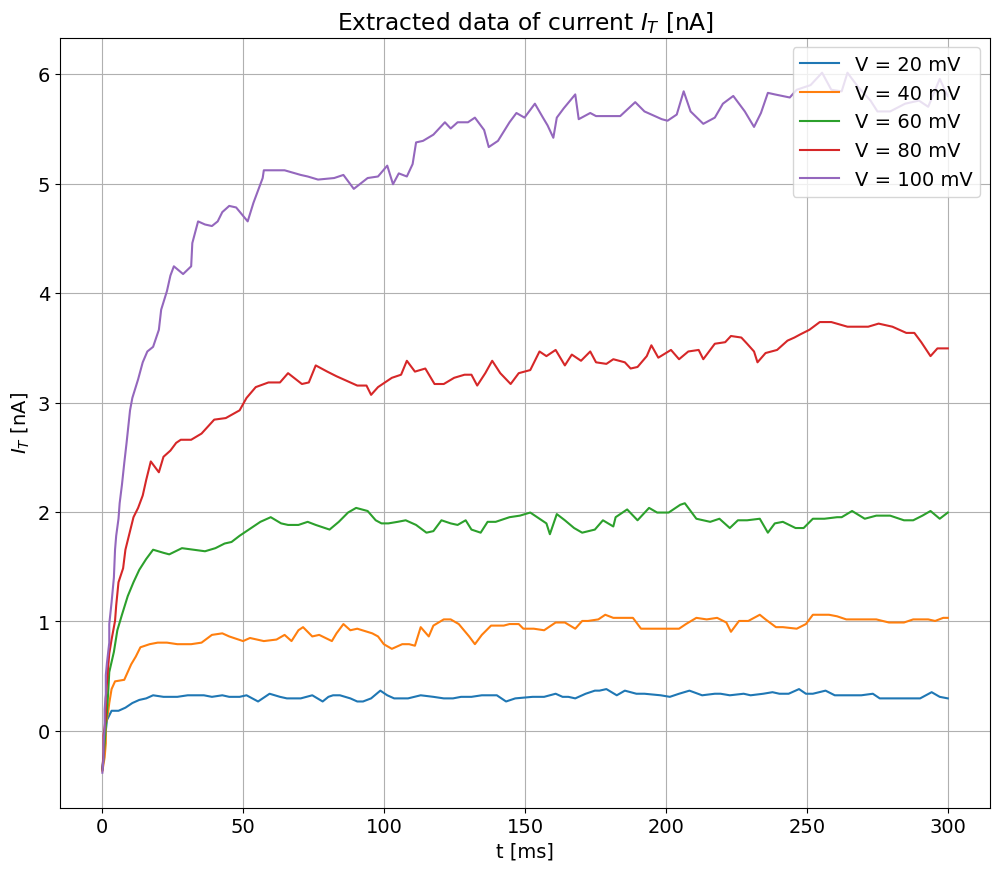

In [107]:
# Look at what the data I extracted look like
fig, ax= plt.subplots(1,1, figsize= (12,10))
plt.title(r'Extracted data of current $I_T$ [nA]')
for idx, value in enumerate(V_amp_str):
    plt.plot(V_data[value].x, V_data[value].y, label='V = ' + value + " mV")
plt.xlabel("t [ms]")
plt.ylabel(r"$I_T$ [nA]")
plt.grid()
plt.legend(loc='upper right');

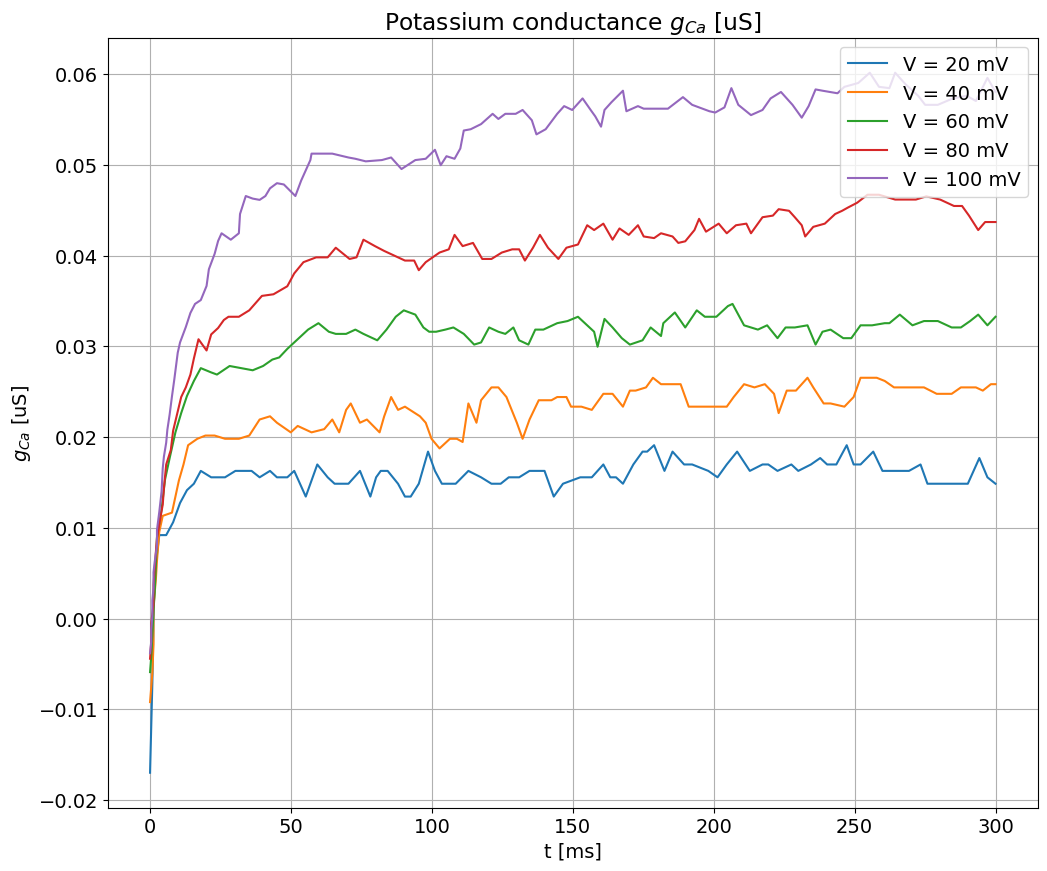

In [108]:
# Look at what the data I extracted look like
fig, ax= plt.subplots(1,1, figsize= (12,10))
plt.title(r'Potassium conductance $g_{Ca}$ [uS]')

for idx, value in enumerate(V_amp_str):
    plt.plot(g_data[value].x, g_data[value].y, label='V = ' + value + " mV")
    
plt.xlabel("t [ms]")
plt.ylabel(r"$g_{Ca}$ [uS]")
plt.grid()
plt.legend(loc='upper right');

## 3.2.Fitting data

In [109]:
#Define the model with symfit
x0, x1, x2, x3, x4, y0, y1, y2, y3, y4 = variables('x0, x1, x2, x3, x4, y0, y1, y2, y3, y4')
g_bar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m = parameters('gbar, Am, Vmm, b1m, c1m, d1m, b2m, c2m, d2m')

g_bar.min=0.001
g_bar.max=1

Am.min= 0.0001
Am.max= 0.1

Vmm.min= -100
Vmm.max= 100

b1m.min= -500
b1m.max= 500
c1m.min= -10
c1m.max= 10
d1m.min= -0.1
d1m.max= 0.1
b2m.min= -500
b2m.max= 500
c2m.min= -10
c2m.max= 10
d2m.min= -0.1
d2m.max= 0.1


alpham = []
betam = []
m_inf = []
tau_m = []


g_base = 0.005
h = 1
V_m0 = -80.01
alpham0 = (Am*exp(-(b1m*(V_m0-Vmm) + c1m*(V_m0-Vmm)**2 + d1m*(V_m0-Vmm)**3)/(R*T)))
betam0 = (Am*exp(-(b2m*(V_m0-Vmm) + c2m*(V_m0-Vmm)**2 + d2m*(V_m0-Vmm)**3)/(R*T)))

m0 = (alpham0)/(alpham0+betam0) 

m = []
x = [x0, x1, x2, x3, x4]

t_on = 0 #[ms] Start time of the stimulation


for i in range(len(V_amp_str)):

    alpham.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    betam.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

    m_inf.append(alpham[i]/(alpham[i]+betam[i]))
    tau_m.append(1/(alpham[i]+betam[i]))

    m.append(m_inf[i] - (m_inf[i] - m0)*exp(-(x[i]-t_on)/tau_m[i]))

model = Model({
    y0: g_bar*h*(m[0]),
    y1: g_bar*h*(m[1]),
    y2: g_bar*h*(m[2]),
    y3: g_bar*h*(m[3]),
    y4: g_bar*h*(m[4]),
})

In [110]:
fit = Fit(model, 
        x0 = V_data['20'].x.to_numpy(), y0 = g_data['20'].y.to_numpy(),
        x1 = V_data['40'].x.to_numpy(), y1 = g_data['40'].y.to_numpy(),
        x2 = V_data['60'].x.to_numpy(), y2 = g_data['60'].y.to_numpy(),
        x3 = V_data['80'].x.to_numpy(), y3 = g_data['80'].y.to_numpy(),
        x4 = V_data['100'].x.to_numpy(), y4 = g_data['100'].y.to_numpy(),
        minimizer= [DifferentialEvolution, LBFGSB])
fit_result = fit.execute(DifferentialEvolution={'popsize': 50, 'recombination': 0.9, 'workers':-1})

In [111]:
print(fit_result)


Parameter Value        Standard Deviation
Am        4.119109e-02 2.661493e-03
Vmm       6.236293e+01 4.240361e+00
b1m       -1.056736e+01 9.277817e+00
b2m       6.257253e+01 1.011417e+01
c1m       -9.273044e-02 1.496842e-01
c2m       5.045968e-01 1.749684e-01
d1m       1.742708e-05 6.947921e-03
d2m       1.177910e-02 9.370163e-03
gbar      6.574555e-02 4.173145e-03
Status message         CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations   365
Objective              <symfit.core.objectives.LeastSquares object at 0x000001B6C9F46830>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x000001B6C9F468F0>, <symfit.core.minimizers.LBFGSB object at 0x000001B6C9F46890>])

Goodness of fit qualifiers:
chi_squared            0.002908897359911915
objective_value        0.0014544486799559575
r_squared              0.9547387921303307


In [112]:
y_fit = model(x0 = V_data['20'].x.to_numpy(), 
              x1 = V_data['40'].x.to_numpy(), 
              x2 = V_data['60'].x.to_numpy(), 
              x3 = V_data['80'].x.to_numpy(), 
              x4 = V_data['100'].x.to_numpy(),**fit_result.params)

In [113]:
test = [y_fit[0], y_fit[1],y_fit[2], y_fit[3],y_fit[4]]

Fit: 20 mV, with adjusted R2=0.7324443812023937
Fit: 40 mV, with adjusted R2=0.8601451955631436
Fit: 60 mV, with adjusted R2=0.9540003267086449
Fit: 80 mV, with adjusted R2=0.9611790713585714
Fit: 100 mV, with adjusted R2=0.9701144462602008


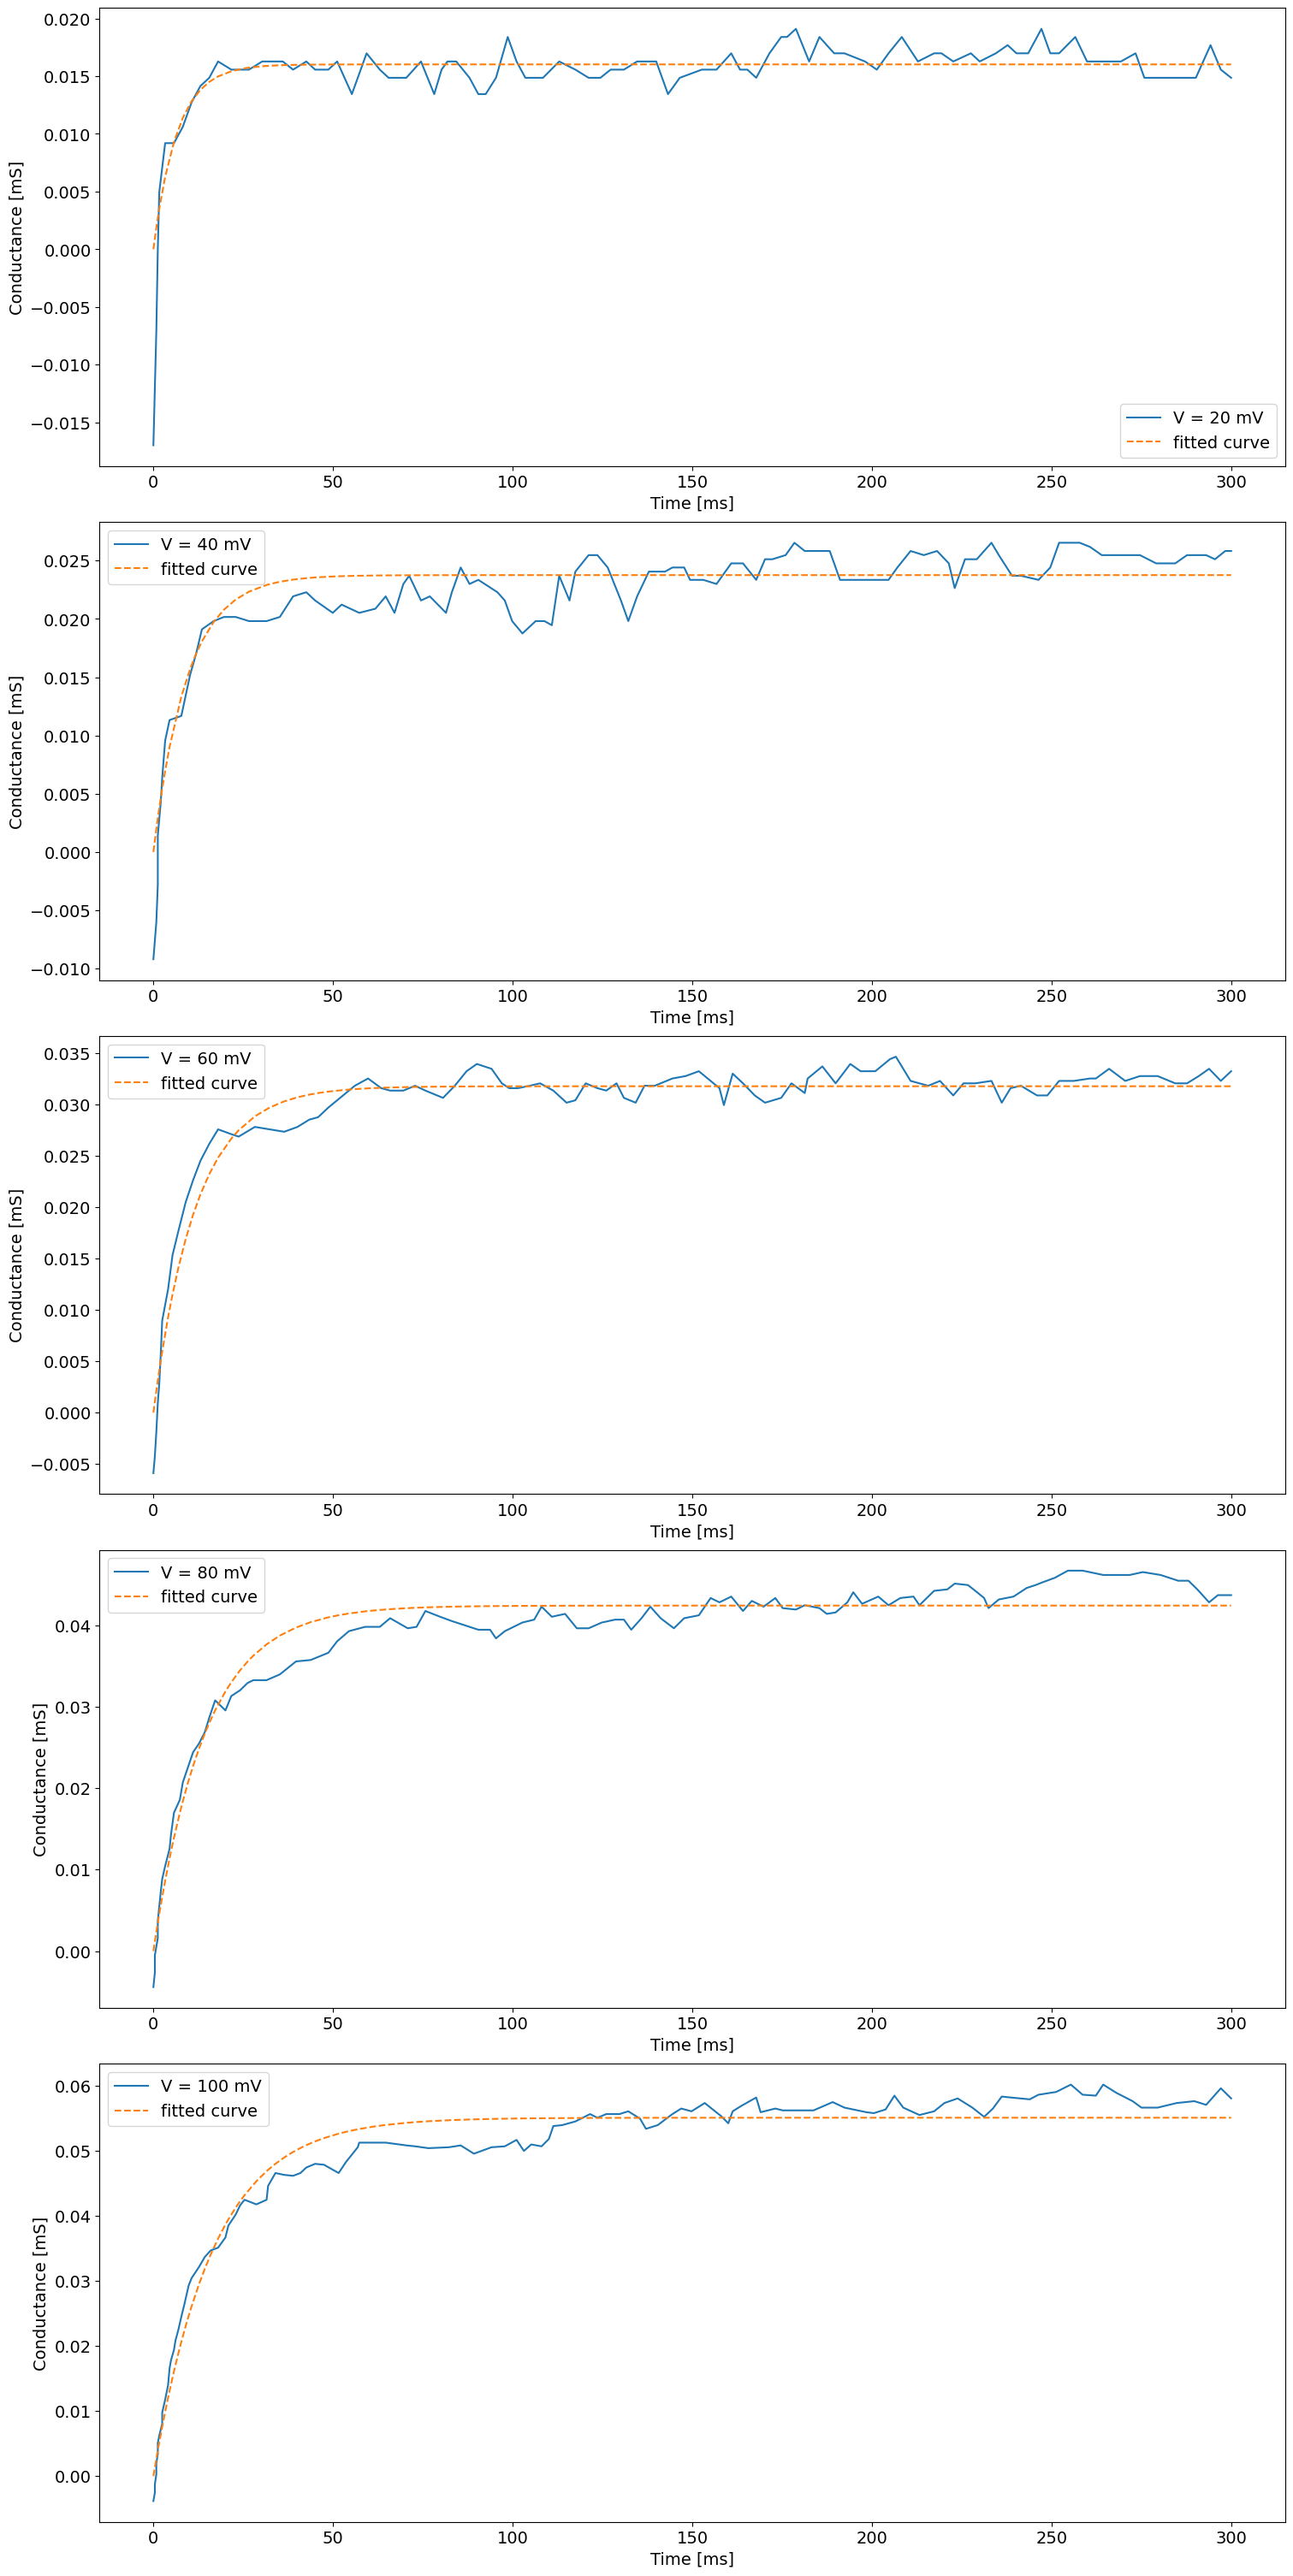

In [116]:
fig, ax= plt.subplots(5, 1, constrained_layout=True, figsize=(15, 30))

for idx, value in enumerate(V_amp_str):
    
    ax[idx].plot(g_data[value].x, g_data[value].y, label= 'V = ' + value + " mV")
    ax[idx].plot(g_data[value].x, test[idx], '--',  label = 'fitted curve')
    ax[idx].set_xlabel('Time [ms]')
    ax[idx].set_ylabel('Conductance [mS]')
    ax[idx].legend()
    print('Fit: {} mV, with adjusted R2={}'.format(value, adjusted_coeff_determ(g_data[value].y, test[idx], len(V_data[value].x), 9)))

plt.savefig('Figures/fit_pos_exp_data.png')


In [117]:
Am = fit_result.params['Am']
Vmm = fit_result.params['Vmm']
b1m = fit_result.params['b1m']
b2m = fit_result.params['b2m']
c1m = fit_result.params['c1m']
c2m = fit_result.params['c2m']
d1m = fit_result.params['d1m']
d2m = fit_result.params['d2m']
gbar = fit_result.params['gbar']

In [118]:
alpha = []
beta = []
n_inf = []
tau = []

for i, value in enumerate(V_amp):
    alpha.append(Am*exp(-(b1m*(V_amp[i]-Vmm) + c1m*(V_amp[i]-Vmm)**2 + d1m*(V_amp[i]-Vmm)**3)/(R*T)))
    beta.append(Am*exp(-(b2m*(V_amp[i]-Vmm) + c2m*(V_amp[i]-Vmm)**2 + d2m*(V_amp[i]-Vmm)**3)/(R*T)))

for i, value in enumerate(V_amp):
    n_inf.append(alpha[i]/(alpha[i]+beta[i]))
    tau.append(1/(alpha[i]+beta[i]))

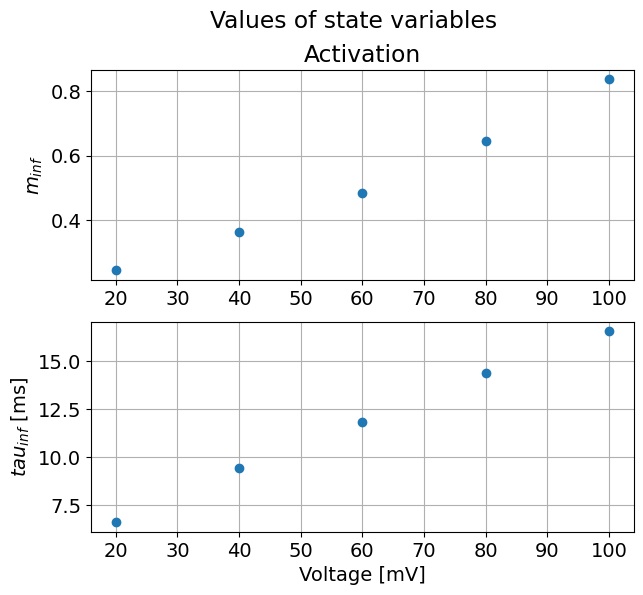

In [120]:
fig, ax = plt.subplots(2,1,figsize= (7,6))
fig.suptitle('Values of state variables')

ax[0].plot(V_amp, n_inf, 'o')
ax[0].set_ylabel(r'$m_{inf}$')
ax[0].grid()
ax[0].set_title('Activation')

ax[1].plot(V_amp, tau, 'o')
#ax[0][1].set_ylim(-0.1, 1.1)
ax[1].set_ylabel(r'$tau_{inf}$ [ms]')
ax[1].set_xlabel('Voltage [mV]')
ax[1].grid()

plt.savefig('Figures/state_var_pos_exp.png')

